In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import Normal
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima_process import ArmaProcess # To generate sample data

In [3]:
stoxx500 = pd.read_csv('data/QRM-2025-cw1-data-a(1).csv')
stoxx500.head()

,Date,Adj Close
0,30/10/2013,3040.689941
1,31/10/2013,3067.949951
2,01/11/2013,3052.139893
3,04/11/2013,3061.179932
4,05/11/2013,3035.919922


In [5]:
stoxx500['log_return'] = (np.log(stoxx500['Adj Close']) - np.log(stoxx500['Adj Close'].shift(1)))*100 #in percentage

In [15]:
lr_features = stoxx500['log_return'].aggregate(['mean', 'skew', 'kurtosis', 'std'])

In [16]:
lr_features

mean         0.011775
skew        -0.795974
kurtosis    10.278073
std          1.239143
Name: log_return, dtype: float64

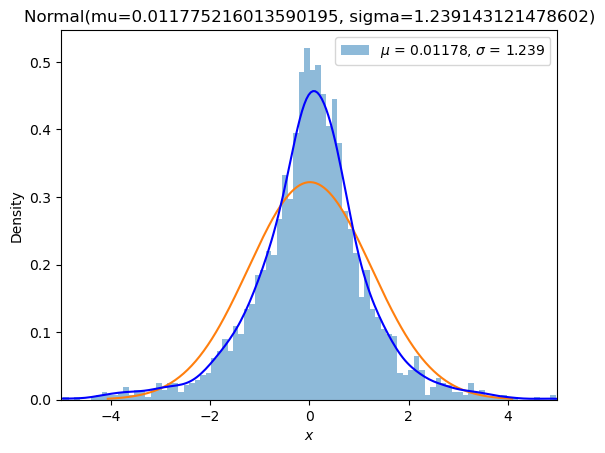

In [76]:
### Normal ditstrib parameterization
mu, skew, kurt, std = lr_features

figure = plt.Figure(figsize=(12,20))
stoxx500['log_return'].plot(kind='hist', density=True, bins = 200, alpha=0.5)
Normal(mu=mu, sigma=std).plot()
stoxx500['log_return'].plot(kind='kde', color='blue')
plt.xlim(-5, 5)
plt.show()

(i) We can conclude that a fitted normal law is not a good approximation for the stock index. Indeed, the index kde has a kurtosis > 3, resulting in thicker tails, and sharper spike.

In [29]:
stoxx500['abs_returns'] = stoxx500['log_return'].apply(abs)
stoxx500['sq_returns'] = stoxx500['log_return'].apply(lambda x: x**2)
stoxx500.head()

,Date,Adj Close,log_return,abs_returns,sq_returns
0,30/10/2013,3040.689941,NaN,NaN,NaN
1,31/10/2013,3067.949951,0.892513,0.892513,0.796579
2,01/11/2013,3052.139893,-0.516662,0.516662,0.266940
3,04/11/2013,3061.179932,0.295749,0.295749,0.087468
4,05/11/2013,3035.919922,-0.828596,0.828596,0.686571


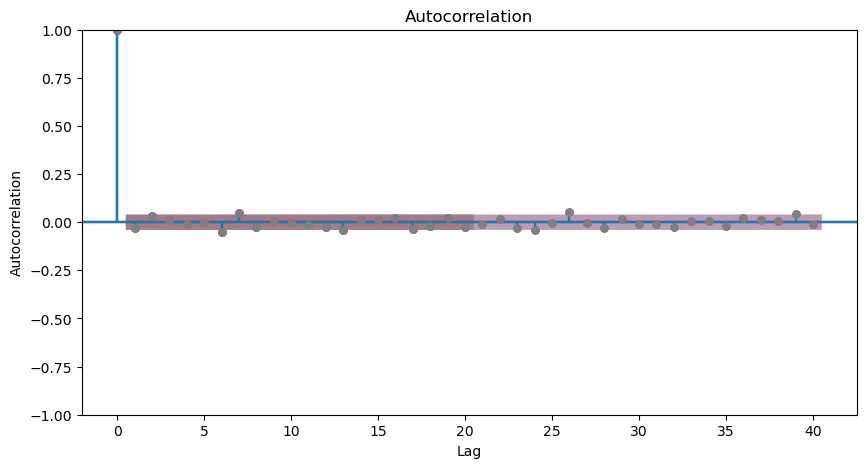

In [83]:
x = stoxx500['log_return'].dropna()
plot_acf(x, lags=40, ax=ax) 

<Axes: >

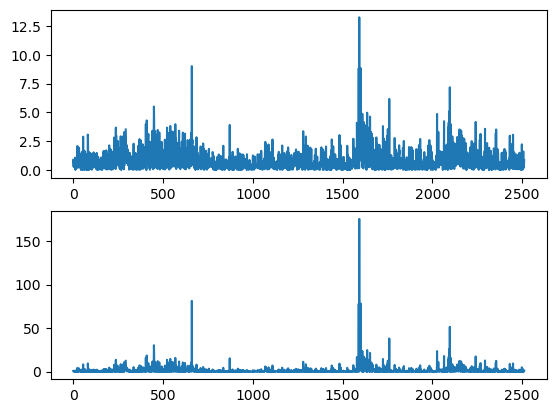

In [ ]:
plt.subplot(2, 1, 1)
stoxx500['abs_returns'].plot()
plt.subplot(2, 1, 2)
stoxx500['sq_returns'].plot()
